# feature importances

There are a number of ways to compute feature importances and **the default estimates reported by scikit learn can be shown to be biased** under certain circumstances.  In addition, many non-tree algorithms do not provide conveniently calculated feature importance estimates. The following demonstration is based on material that draws heavily from the following sources:

## references


### repos

* **[Feature importances for scikit-learn machine learning models](https://github.com/parrt/random-forest-importances)**,  [MIT License](https://github.com/parrt/random-forest-importances/blob/master/LICENSE)
* **[Scikit-Learn ensemble module - forests](https://github.com/scikit-learn/scikit-learn/blob/0.23.1/sklearn/ensemble/_forest.py)**, [BSD License](https://github.com/scikit-learn/scikit-learn/blob/fd237278e895b42abe8d8d09105cbb82dc2cbba7/sklearn/ensemble/_forest.py#L40)
* **[ELI5 - Permutation Importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)**  

### articles

Strobl, C., Boulesteix, A., Zeileis, A. et al. **[Bias in random forest variable importance measures: Illustrations, sources and a solution](https://link.springer.com/article/10.1186/1471-2105-8-25#citeas)**. BMC Bioinformatics 8, 25 (2007). https://doi.org/10.1186/1471-2105-8-25  

Strobl, C., Boulesteix, A., Kneib, T. et al. **[Conditional variable importance for random forests](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307#citeas)**. BMC Bioinformatics 9, 307 (2008). https://doi.org/10.1186/1471-2105-9-307  

## what we'll do

* demonstrate an issue with default feature importance estimates  
* provide alternatives and compare to the default  
* create a new function `feature_perms` that implements a computationally simple algorithm 
* create a new function `dropcol_importances` that implements a computationally intensive algorithm that is more accurate
* test our new functions

It should be noted that although we are developing this notebook using a classification example, an almost identical presentation can be done for regression.

## imports

In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.base import clone

from sklearn.ensemble import RandomForestClassifier as SomeModel

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union, Callable, List

## default feature importances

This is a function that plots default feature importances from an estimated model object when available.  It is taken from mlrun's current source-code implementation:

In [2]:
def feature_importances(
    model: SomeModel,
    header: List[str], 
    figsz=(10, 5)
) -> None:
    """Display default model feature importances

    Only works for models with attribute 'feature_importances_`

    :param model:       fitted model with a feature_importances_ attribute
    :param header:      feature labels
    :param figsz:       matplotlib figure size
    """
    if not hasattr(model, "feature_importances_"):
        raise Exception(
            "feature importances are only available for some models")

    # create a feature importance table with desired labels
    zipped = zip(model.feature_importances_, header)
    feature_imp = pd.DataFrame(
        sorted(zipped), columns=["freq", "feature"]).sort_values(
            by="freq", ascending=False)

    plt.clf()
    plt.figure(figsize=figsz)
    sns.barplot(x="freq", y="feature", data=feature_imp)
    plt.title("features")
    plt.tight_layout();
    
    return feature_imp

## permuted features

A proposed solution that has general applicability is randomly permuted features<sup>**[refs](#references)**</sup>:  
* loop through the feature set  
* shuffle one feature  
* run predict
* compare the (marginal) change in accuracy (or other metric of interest) 

This approach is computationally more demanding than relying on the default values, however it can be easily parallelized. To perform the estimation we only need an estimated model and a held-out test set.  The following was proposed in **[Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)**:

( the following 3 glue functions will no longer be publicly visible in  the sklearn package from 0.24 onwards, consider this a temporary hack while we refactor these away)

**the following has been  refactored in final version of function:**

In [3]:
from distutils.version import LooseVersion
import numpy as np
from sklearn.utils import check_random_state

def _generate_sample_indices(random_state: int, n_samples: int, n_samples_bootstrap: int):
    """
    Private function used to _parallel_build_trees function.
    taken from:
    https://github.com/scikit-learn/scikit-learn/blob/2253807bb488b6de73796aef2de38a6dcf282d86/sklearn/ensemble/_forest.py#L116
    (public availability to be deprecated by sklearn v0.24)
    """
    random_instance = check_random_state(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_samples_bootstrap)

    return sample_indices

def _generate_unsampled_indices(random_state: int, n_samples: int, n_samples_bootstrap: int):
    """
    Private function used to forest._set_oob_score function.
    taken from: 
    https://github.com/scikit-learn/scikit-learn/blob/2253807bb488b6de73796aef2de38a6dcf282d86/sklearn/ensemble/_forest.py#L126
    (public availability to be deprecated by sklearn v0.24)
    """
    sample_indices = _generate_sample_indices(random_state, n_samples,
                                              n_samples_bootstrap)
    sample_counts = np.bincount(sample_indices, minlength=n_samples)
    unsampled_mask = sample_counts == 0
    indices_range = np.arange(n_samples)
    unsampled_indices = indices_range[unsampled_mask]

    return unsampled_indices

def _get_unsampled_indices(tree, n_samples: int):
    """
    An interface to get unsampled indices regardless of sklearn version.
    """
    import warnings
    warnings.simplefilter(action="ignore", category=FutureWarning)
    if LooseVersion(sklearn.__version__) >= LooseVersion("0.22"):
        # Version 0.22 or newer uses 3 arguments.
        from sklearn.ensemble.forest import _get_n_samples_bootstrap
        n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, n_samples)
        return _generate_unsampled_indices(tree.random_state, n_samples,
                                           n_samples_bootstrap)
    else:
        # Version 0.21 or older uses only two arguments.
        return _generate_unsampled_indices(tree.random_state, n_samples)

The following function estimates classifier accuracy and has been borrowed from **[references](#references)**. See **[breitman on oob](https://www.stat.berkeley.edu/~breiman/OOBestimation.pdf)** for details on out-of-bag estimation:

In [4]:
def oob_classifier_accuracy(rf, X_train: np.array, y_train: np.array) -> float:
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn forest classifier.
    
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _get_unsampled_indices(tree, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    
    return oob_score

Putting it all together:

In [13]:
def permutation_importances(
    model, 
    X_train: np.array,
    y_train: np.array, 
    header: List[str],
    metric: Callable = oob_classifier_accuracy,
    figsz=(10, 5)
) -> np.array:
    """calculate change in metric from permuting feature columns
    
    modified from https://explained.ai/rf-importance/index.html
    
    uses a pre-estimated model

    :param X_train:     training set features
    :param y_train:     training set ground truths, regression targets
    :param header:      column labels for X_train
    :param figsz:       matplotlib figure size
    
    """
    baseline = metric(model, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(model, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
        
    # create a feature importance table with desired labels
    zipped = zip(imp, header)
    feature_imp = pd.DataFrame(sorted(zipped), columns=["importance", "feature"])
    feature_imp.sort_values(by="importance", ascending=False, inplace=True)

    plt.clf()
    plt.figure(figsize=figsz)
    sns.barplot(x="importance", y="feature", data=feature_imp)
    plt.title("feature permutation importances")
    plt.tight_layout()

    return np.array(feature_imp)

## drop-column importances

According to our **[references](#references)** a more accurate measure of feature importance would have us re-estimate the model after dropping a column.  This is considered as being close to "ideal".  Unfortunately, the entire model needs to be re-estimated for each column and without some approximating shortcut this is likely to be infeasible for large datasets.

Here is the suggested implementation and **don't run this on big models!**:

In [14]:
def dropcol_importances(
    model, 
    X_train: np.array,
    y_train: np.array,
    header: List[str] = [],
    random_state: int = 1994,
    figsz=(10, 5)
) -> pd.DataFrame:
    """drop columns and re-estimate model
    
    modified from https://explained.ai/rf-importance/index.html
    
    :param rf:         model to fit
    :param X_train:    training set features
    :param y_train:    training set ground truth labels

    Returns:
        pd.DataFrame:  table of diffs vs baseline metric
    """
    # cloning makes copy of model pre-fit
    # calculate a baseline with all features
    model_ = clone(model)
    model_.random_state = random_state
    model_.fit(X_train, y_train)
    baseline = model_.oob_score_
    
    # now drop each colum, refit model and calc metric
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        model_ = clone(model)
        model_.random_state = random_state
        model_.fit(X, y_train)
        o = model_.oob_score_
        imp.append(baseline - o)
    
    # put it all in a table
    imp = np.array(imp)
    feature_imps = pd.DataFrame(
        data={'feature': X_train.columns,
              'importance': imp})
    #feature_imps.set_index('feature', inplace=True)
    feature_imps.sort_values('importance', ascending=True, inplace=True)
    
    plt.clf()
    plt.figure(figsize=figsz)
    sns.barplot(x="importance", y="feature", data=feature_imps)
    plt.title("drop column feature importances")
    plt.tight_layout()
    
    return feature_imps

## demonstration

In this demonstratuon we are going to take a fraction of a fraction of **[Kaggle's RentHop rental listing interest competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries)**--the complete dataset is presently >80GB, we'll be looking at 5K rows.  

The competition's **[goal](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries)** was
> to predict the number of inquiries a new listing receives based on the listing’s creation date and other features.  

Doing so would help **[RentHop](https://www.renthop.com/)**
> better handle fraud control, identify potential listing quality issues, and allow owners and agents to better understand renters’ needs and preferences.

In [15]:
data = "/User/artifacts/two-sigma-connect-rental-listing-inquiries/"
NFRAC = 0.1

In [16]:
df = pd.read_csv(data + 'rent.csv').sample(frac=NFRAC)
print("sample dimensions", df.shape)
df.head(3)

sample dimensions (4935, 6)


,bathrooms,bedrooms,price,longitude,latitude,interest_level
18235,1.0,0,1800,-73.9960,40.7197,2
42140,1.0,2,3000,-73.9879,40.7653,3
4677,1.0,1,1350,-73.8996,40.8549,2


In [17]:
features = ['bathrooms', 'bedrooms', 'longitude', 'latitude', 'price']
dfr = df[features]

# drop price column
X_train, y_train = dfr.drop('price', axis=1), dfr['price']

# insert column with random values
X_train['random'] = np.random.random(size=len(X_train))
features = ['bathrooms', 'bedrooms', 'longitude', 'latitude', 'random']

In [18]:
# define model
model_params = {
    "n_estimators"     : 100, 
    "min_samples_leaf" : 1,
    "n_jobs"           : -1,
    "oob_score"        : True
}

model = SomeModel(**model_params)

# estimate
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True)

### to run this the model needs a default attribute

default feature_importances [0.01683784 0.03215169 0.29983429 0.30418813 0.34698806]


<Figure size 432x288 with 0 Axes>

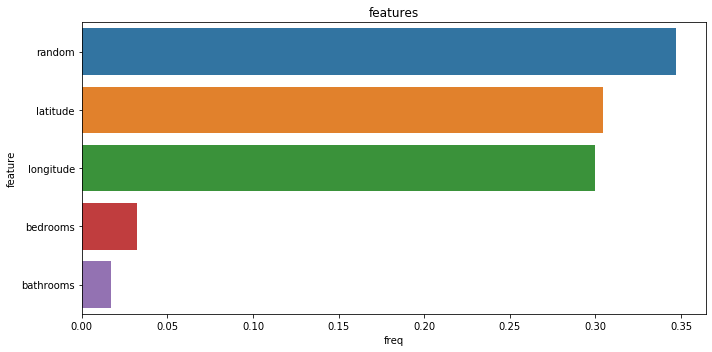

In [19]:
if hasattr(model, "feature_importances_"):
    print("default feature_importances", model.feature_importances_)
    feature_importances(model, features)

## permutation importances

No need to check for default attributes or functions, this can be run on any kind of model:

array([[0.06545086119554205, 'longitude'],
       [0.06160081053698076, 'latitude'],
       [0.053495440729483285, 'bedrooms'],
       [0.021681864235055734, 'bathrooms'],
       [0.0004052684903748799, 'random']], dtype=object)

<Figure size 432x288 with 0 Axes>

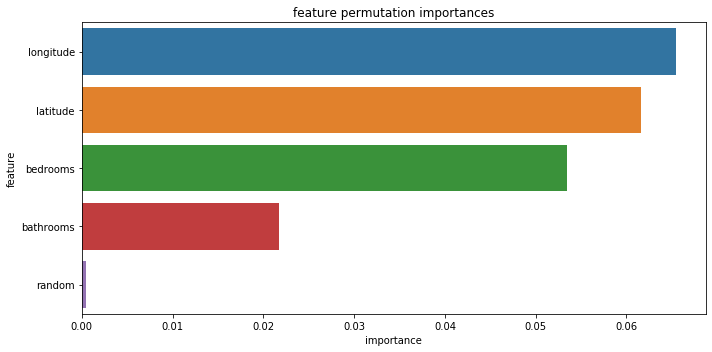

In [20]:
pi = permutation_importances(model, X_train, y_train, features)
pi

## drop-column importances

,feature,importance
4,random,-0.042756
0,bathrooms,0.001824
1,bedrooms,0.023100
2,longitude,0.049240
3,latitude,0.051874


<Figure size 432x288 with 0 Axes>

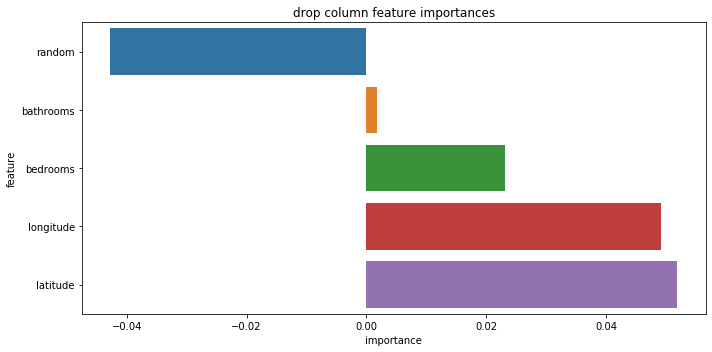

In [21]:
dc = dropcol_importances(model, X_train, y_train)
dc

## conclusions

So I would say location is a prime factor, then the number of bedrooms.  Bathrooms often is gte bedrooms, and is likely correlated so one of them should likely be dropped.